In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import aesara.tensor as at
from pytensor.tensor.subtensor import set_subtensor as set_st
from pymc.math import eq
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext lab_black
%load_ext watermark

# Hald

Adapted from [Unit 9: Hald.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/Hald.odc) and [Haldssvs.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/Haldssvs.odc).

Associated lecture videos: Unit 9 lessons 4 and 10.

## Problem statement

A dataset on Portland cement originally due to Woods, Steinour and Starke (1932), and which has since then been widely analysed is now referred as Hald data cf. e.g., Hald (1952, pp. 635†652),

These data come from an experimental investigation of the heat evolved during the setting and hardening of Portland cements of varied composition and the dependence of this heat  on the percentages of four compounds in the clinkers from which the cement was  produced.

As observed by Woods, Steinour and Starke (1932, p. 1207): 
>This property is of interest in the construction of massive works such as dams, in which the great thicknesses severely hinder the outflow of the heat. The consequent rise in temperature while the cement is hardening may result in contractions and cracking when the eventual cooling to the surrounding temperature takes place. 

The four compounds considered by Woods, Steinour and Starke (1932) are tricalcium aluminate: 3CaO-Al2O3, tricalcium silicate: 3CaO-SiO2, tetracalcium aluminoferrite: 4CaO-Al2O3-Fe2O3, and beta-dicalcium silicate: 2CaO-SiO2, which we will denote by x1, x2, x3, and x4, respectively. The heat evolved after 180 days of curing, which we will denote by y, is measured in calories per gram of cement.

REFS:
Hald, Anders (1952). Statistical Theory with Engineering Applications. Wiley, New York.

Woods, H., Steinour, H. H., and Starke, H. R. (1932). Effect of composition
of Portland cement on heat evolved during hardening. Industrial and Engineering
Chemistry, 24, 1207†1214.




In [2]:
data = pd.read_csv("../data/hald_data.csv")
y = data["y"].to_numpy()
X = data.drop("y", axis=1).to_numpy()

In [3]:
Y = y.repeat(7).reshape(13, 7)

## Model 1

This was a pain to type out. Would be nice to find a cleaner method.

Model 1 shows how to use the Laud-Ibrahim criterion ([Laud and Ibrahim, 1995](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02028.x)) to choose between models. The L metric is based on a comparison between the original target variable and the posterior predictive distribution. In the BUGS example, the ```Y.new``` contains the results of the Posterior Predictive Check (PPC). As the variable name indicates, it's just a set of new Y values generated from the posterior. The L metric is a measure of distance between the original y values and the PPC. The lower L is, the better.

```{note}
The BUGS example has 8 models, but I only have 7 here. That's because models 6 and 8 were identical, so I just dropped model 8.
```

In [4]:
with pm.Model() as m:
    a = pm.Normal("a", 0, tau=0.00001, shape=4)
    b = pm.Normal("b", 0, tau=0.00001, shape=4)
    c = pm.Normal("c", 0, tau=0.00001, shape=4)
    d = pm.Normal("d", 0, tau=0.00001, shape=5)
    e = pm.Normal("e", 0, tau=0.00001, shape=3)
    f = pm.Normal("f", 0, tau=0.00001, shape=3)
    g = pm.Normal("g", 0, tau=0.00001, shape=4)
    tau = pm.Gamma("tau", 12.5, 62.5, shape=7)
    # fmt: off
    _mu = [
        a[0] + a[1] * X[:, 0] + a[2] * X[:, 1] + a[3] * X[:, 3],  # i013
        b[0] + b[1] * X[:, 0] + b[2] * X[:, 1] + b[3] * X[:, 2],  # i012
        c[0] + c[1] * X[:, 0] + c[2] * X[:, 2] + c[3] * X[:, 3],  # i023
        d[0] + d[1] * X[:, 0] + d[2] * X[:, 1] + d[3] * X[:, 2] + d[4] * X[:, 3],  # i0123
        e[0] + e[1] * X[:, 0] + e[2] * X[:, 1],  # i01
        f[0] + f[1] * X[:, 0] + f[2] * X[:, 3],  # i03
        g[0] + g[1] * X[:, 1] + g[2] * X[:, 2] + g[3] * X[:, 3],  # i123
    ]
    # fmt: on
    mu = pm.math.stack(_mu, name="mu")
    pm.Normal("likelihood", mu=mu.T, tau=tau, observed=Y)

    trace = pm.sample(5000, target_accept=0.95)

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, e, f, g, tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1135 seconds.
Sampling: [likelihood]


In [5]:
Y_new = az.summary(trace.posterior_predictive)["mean"].values.reshape(13, 7)
D2 = (Y - Y_new) ** 2
L = np.sqrt(np.sum(D2, axis=0) + np.std(Y_new, axis=0) ** 2)

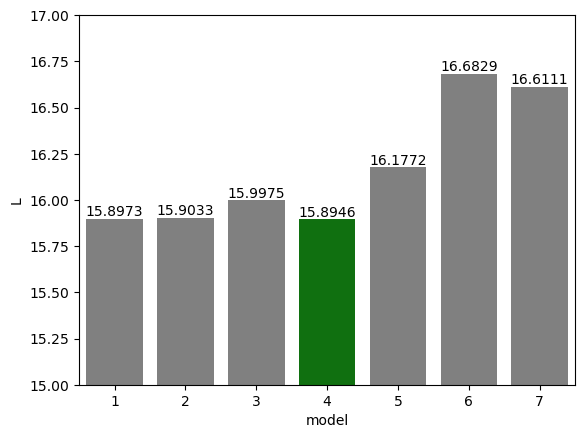

In [6]:
colors = ["grey" if m > L.min() else "green" for m in L]
bp = sns.barplot(x=list(range(1, 8)), y=L, palette=colors)
bp.set(ylim=(15, 17), xlabel="model", ylabel="L")
bp.bar_label(bp.containers[0])
plt.show()

The results are not identical to BUGS, so I may need to come back and double-check this. I also haven't calculated the model-by-model comparisons.

## Model 2: Stochastic Search Variable Selection (SSVS)

In [7]:
X_centered = (X - X.mean(axis=0)) / X.std(axis=0)

In [8]:
_, p = X.shape
draws = 10000
chains = 4

with pm.Model() as m_svss:
    # SVSS prior
    delta = pm.Bernoulli("delta", p=0.5, shape=p)
    alpha = pm.Normal("alpha", 0, tau=0.1, shape=p)
    beta = pm.Deterministic("beta", delta * alpha)

    tau = pm.Gamma("tau", 0.1, 0.1)
    intercept = pm.Normal("intercept", 0, tau=0.001)

    mu = intercept + pm.math.dot(X_centered, beta)
    pm.Normal("likelihood", mu, tau=tau, observed=y)

    trace = pm.sample(draws=draws, chains=chains, target_accept=0.95)

/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [delta]
>NUTS: [alpha, tau, inte

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 33 seconds.


In [9]:
az.summary(trace, var_names="delta", kind="stats")

,mean,sd,hdi_3%,hdi_97%
delta[0],0.999,0.024,1.0,1.0
delta[1],0.929,0.257,0.0,1.0
delta[2],0.425,0.494,0.0,1.0
delta[3],0.940,0.238,0.0,1.0


Delta values, representing how often each feature was selected for the model, match the BUGS results. But what about looking at how often each model was selected? I really don't want to code that quadruple for-loop (the model variable in the BUGS example) or try to vectorize it.

Let's look in the trace. We can view the delta variable across all chains and samples.

In [10]:
trace.posterior.delta

<xarray.DataArray 'delta' (chain: 4, draw: 10000, delta_dim_0: 4)>
array([[[1, 1, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        ...,
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 0]],

       [[1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        ...,
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1]],

       [[1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        ...,
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0]],

       [[1, 1, 0, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        ...,
        [1, 1, 0, 1],
        [1, 1, 0, 1],
        [1, 1, 0, 1]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * delta_dim_0  (delta_dim_0) int64 0 1 2 3

We just need a way to count each unique combination of predictors. I didn't see an obvious way to do that in xarray, so I'm copying the delta values to a NumPy array, then reshaping to include all draws for each chain along dimension 0, and finally getting the unique vectors of length p along with their counts, which we can use to calculate the probability of each model being selected.

In [11]:
rows = chains * draws

deltas = trace.posterior.delta.to_numpy()
models, counts = np.unique(deltas.reshape((rows, p)), axis=0, return_counts=True)

for model, count in zip(models, counts):
    print(f"{model}: prob={count/rows:.3}")

[0 0 1 1]: prob=0.00025
[0 1 1 1]: prob=0.00035
[1 0 0 1]: prob=0.0128
[1 0 1 1]: prob=0.0581
[1 1 0 0]: prob=0.0419
[1 1 0 1]: prob=0.52
[1 1 1 0]: prob=0.0184
[1 1 1 1]: prob=0.348


The most chosen models are the same as BUGS: intercept + x0 + x1 + x3 is selected over 50% of the time, intercept + x0 + x1 + x2 + x3 about a third of the time, and so on.

In [12]:
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Fri Feb 03 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

aesara: 2.8.10
aeppl : 0.1.1

pandas    : 1.5.3
matplotlib: 3.6.3
arviz     : 0.14.0
seaborn   : 0.12.2
numpy     : 1.24.1
pymc      : 5.0.1
aesara    : 2.8.10

